# Covert Units

In [1]:
def convert_to_appropriate_units(value):
    if 100 <= value < 1000:
        return f"{value:.2f} Hundred"
    elif 1000 <= value < 1000000:
        return f"{value / 1000:.2f} Thousand"
    elif 1000000 <= value < 1000000000:
        return f"{value / 1000000:.2f} Million"
    elif value >= 1000000000:
        return f"{value / 1000000000:.2f} Billion"
    else:
        return str(value)

# Population Growth by Regions

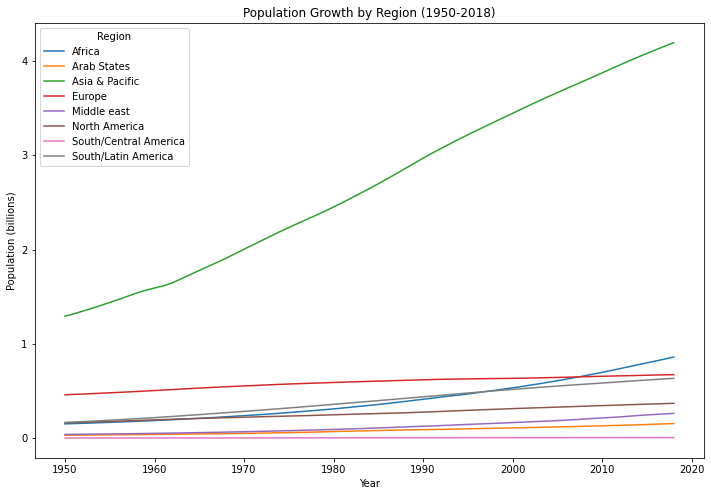

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

pop_df = pd.read_csv('UN-population-projection-medium-variant.csv')
country_region_df = pd.read_html('https://meta.wikimedia.org/wiki/List_of_countries_by_regional_classification')[0]
country_region_df['Country'] = country_region_df['Country'].str.strip()

conn = sqlite3.connect('population_data.db')
country_region_df.to_sql('countries', conn, if_exists='replace', index=False)
pop_df.to_sql('population', conn, if_exists='replace', index=False)

country_region_query = 'SELECT Country, Region FROM countries'
population_query = 'SELECT Entity as Country, Year, `Population 1950-2021` as Pop_1950_2018 FROM population'

country_region_df = pd.read_sql(country_region_query, conn)
pop_df = pd.read_sql(population_query, conn)

pop_merged_df = pd.merge(pop_df, country_region_df, on='Country') 
pop_merged_df = pop_merged_df[(pop_merged_df['Year'] >= 1950) & (pop_merged_df['Year'] <= 2018)] 

country_pop_df = pop_merged_df[['Country', 'Year', 'Pop_1950_2018']].copy()
country_pop_df = country_pop_df.set_index(['Country', 'Year']).sort_index()

region_year_pop_df = pop_merged_df.groupby(['Region', 'Year'])['Pop_1950_2018'].sum()
region_year_pop_df = region_year_pop_df.apply(lambda x: x / 1e9)
region_year_pop_df = region_year_pop_df.reset_index()
table = pd.pivot_table(region_year_pop_df, values='Pop_1950_2018', index='Region', columns='Year', fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
table.T.plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Population (billions)')
ax.set_title('Population Growth by Region (1950-2018)')
plt.show()

# Save the tables to CSV files
table.to_csv('population growth 1950-2018 by region.csv')

# Density Growth by Regions

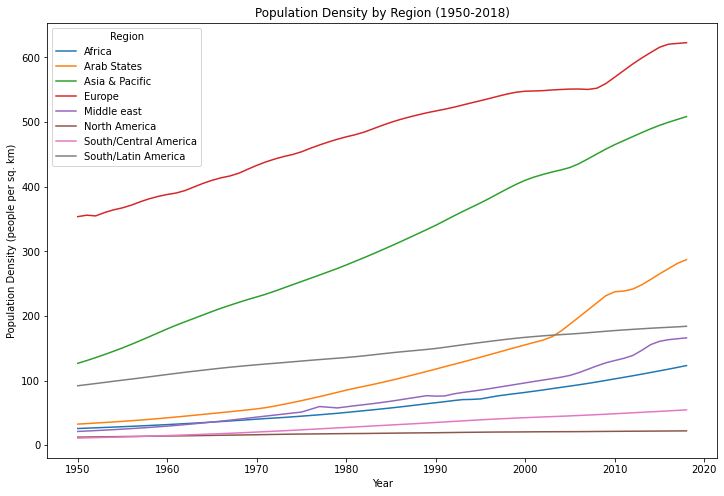

In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

density_df = pd.read_csv('population-density.csv')
country_region_df = pd.read_html('https://meta.wikimedia.org/wiki/List_of_countries_by_regional_classification')[0]
country_region_df['Country'] = country_region_df['Country'].str.strip()

conn = sqlite3.connect('population_density_data.db')
country_region_df.to_sql('countries', conn, if_exists='replace', index=False)
density_df.to_sql('density', conn, if_exists='replace', index=False)

country_region_query = 'SELECT Country, Region FROM countries'
density_query = 'SELECT Entity as Country, Year, `Population density` FROM density'

country_region_df = pd.read_sql(country_region_query, conn)
density_df = pd.read_sql(density_query, conn)

density_merged_df = pd.merge(density_df, country_region_df, on='Country')
density_merged_df = density_merged_df[(density_merged_df['Year'] >= 1950) & (density_merged_df['Year'] <= 2018)]

region_year_density_df = density_merged_df.groupby(['Region', 'Year'])[['Population density']].mean()
region_year_density_df = region_year_density_df.reset_index()

density_table = pd.pivot_table(region_year_density_df, values='Population density', index='Region', columns='Year', fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
density_table.T.plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Population Density (people per sq. km)')
ax.set_title('Population Density by Region (1950-2018)')
plt.show()

# Save the pivot table to a CSV file
density_table.to_csv('population density 1950-2018 by region.csv')

# GDP Growth by Regions

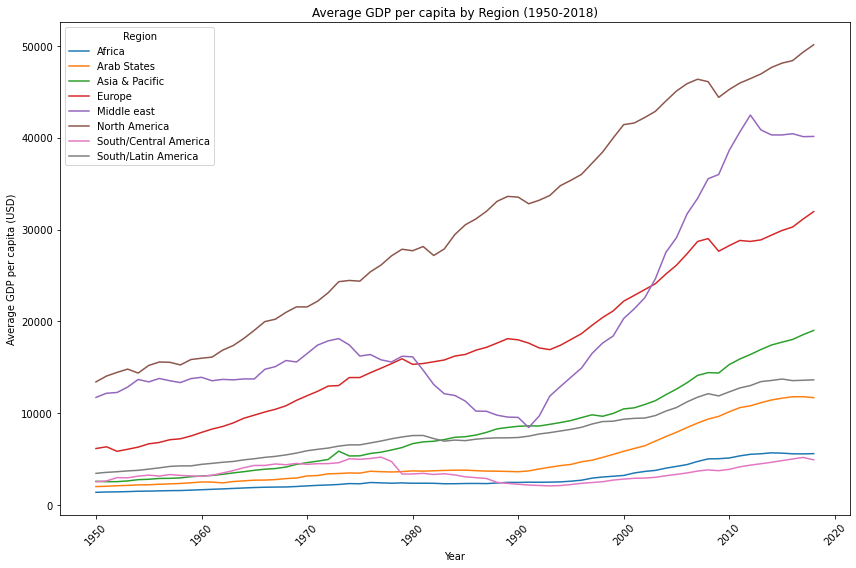

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

gdp_df = pd.read_csv('gdp-per-capita-maddison-2020.csv')
gdp_1950_2018 = gdp_df[(gdp_df['Year'] >= 1950) & (gdp_df['Year'] <= 2018)]

country_region_df = pd.read_html('https://meta.wikimedia.org/wiki/List_of_countries_by_regional_classification')[0]
country_region_df['Country'] = country_region_df['Country'].str.strip()

gdp_merged_df = pd.merge(gdp_1950_2018, country_region_df, left_on='Entity', right_on='Country', how='left')

total_gdp_by_region_year = gdp_merged_df.groupby(['Region', 'Year'])['GDP per capita'].mean().reset_index()

gdp_table = pd.pivot_table(total_gdp_by_region_year, values='GDP per capita', index='Year', columns='Region', fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
gdp_table.plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Average GDP per capita (USD)')
ax.set_title('Average GDP per capita by Region (1950-2018)')
plt.legend(title='Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the pivot table to a CSV file
output_file = 'Average GDP per capita by Region 1950-2018.csv'
gdp_table.to_csv(output_file)

# Top 5 Countries Population Growth 1950-2018

In [5]:
import pandas as pd

pop_merged_df = pop_merged_df[(pop_merged_df['Year'] >= 1950) & (pop_merged_df['Year'] <= 2018)]

pop_1950 = pop_merged_df[pop_merged_df['Year'] == 1950][['Country', 'Pop_1950_2018']]
pop_2018 = pop_merged_df[pop_merged_df['Year'] == 2018][['Country', 'Pop_1950_2018']]

pop_growth_df = pd.merge(pop_1950, pop_2018, on='Country')
pop_growth_df['Population_increase_millions_since_1950-2018'] = (pop_growth_df['Pop_1950_2018_y'] - pop_growth_df['Pop_1950_2018_x']) / 1e6
pop_growth_df['Total_population_2018'] = pop_growth_df['Pop_1950_2018_x'] + (pop_growth_df['Pop_1950_2018_y'] - pop_growth_df['Pop_1950_2018_x'])
pop_growth_df['Starting_population_1950'] = pop_growth_df['Pop_1950_2018_x']

top_5_countries = pop_growth_df.sort_values(by='Population_increase_millions_since_1950-2018', ascending=False).head(5)

# Function to convert numbers to a more readable format
def convert_to_appropriate_units(x, column_name):
    if column_name == 'Starting_population_1950':
        return f"{x / 1_000_000:.2f} Million"
    elif column_name == 'Total_population_2018':
        return f"{x / 1_000_000_000:.2f} Billion" if x >= 1_000_000_000 else f"{x / 1_000_000:.2f} Million"
    elif column_name == 'Population_increase_millions_since_1950-2018':
        return f"{x:.2f} Million"  # Add the unit 'Million' here
    else:
        return f"{x:.2f}"

formatted_data = top_5_countries[['Country', 'Starting_population_1950', 'Population_increase_millions_since_1950-2018', 'Total_population_2018']].copy()
formatted_data['Starting_population_1950'] = formatted_data['Starting_population_1950'].apply(lambda x: convert_to_appropriate_units(x, 'Starting_population_1950'))
formatted_data['Population_increase_millions_since_1950-2018'] = formatted_data['Population_increase_millions_since_1950-2018'].apply(lambda x: convert_to_appropriate_units(x, 'Population_increase_millions_since_1950-2018'))
formatted_data['Total_population_2018'] = formatted_data['Total_population_2018'].apply(lambda x: convert_to_appropriate_units(x, 'Total_population_2018'))

output_file = 'Top 5 Countries Population Growth 1950-2018.csv'
formatted_data.to_csv(output_file, index=False)

print(formatted_data.to_string(index=False))

      Country Starting_population_1950 Population_increase_millions_since_1950-2018 Total_population_2018
        India           357.02 Million                              1011.98 Million          1.37 Billion
        China           543.98 Million                               873.09 Million          1.42 Billion
    Indonesia            69.57 Million                               197.50 Million        267.07 Million
United States           148.28 Million                               183.86 Million        332.14 Million
     Pakistan            37.70 Million                               182.04 Million        219.73 Million


Top 5 Countries Population Growth 1950-2018: GDP Growth 1950-2018

In [6]:
import pandas as pd

gdp_per_capita_df = pd.read_csv('gdp-per-capita-maddison-2020.csv')

countries = ['India', 'China', 'Indonesia', 'Pakistan', 'United States']

gdp_filtered = gdp_per_capita_df[(gdp_per_capita_df['Entity'].isin(countries)) & (gdp_per_capita_df['Year'] >= 1950) & (gdp_per_capita_df['Year'] <= 2018)]
starting_gdp = gdp_filtered[gdp_filtered['Year'] == 1950].set_index('Entity')['GDP per capita']
gdp_increase = gdp_filtered[gdp_filtered['Year'] == 2018].set_index('Entity')['GDP per capita'] - starting_gdp
total_gdp_2018 = gdp_filtered[gdp_filtered['Year'] == 2018].set_index('Entity')['GDP per capita']

gdp_table = pd.DataFrame({
    'Country': countries,
    'Starting_GDP_1950': starting_gdp,
    'GDP_increase_since_1950_2018': gdp_increase,
    'Total_GDP_2018': total_gdp_2018}).reset_index(drop=True)

gdp_table['Starting_GDP_1950'] = gdp_table['Starting_GDP_1950'].apply(lambda x: f"{x:,.2f} USD")
gdp_table['GDP_increase_since_1950_2018'] = gdp_table['GDP_increase_since_1950_2018'].apply(lambda x: f"{x:,.2f} USD")
gdp_table['Total_GDP_2018'] = gdp_table['Total_GDP_2018'].apply(lambda x: f"{x:,.2f} USD")
gdp_table.index = [''] * len(gdp_table)
gdp_table = gdp_table.sort_values(by='Total_GDP_2018', ascending=True)

output_file = 'Top 5 Countries Population Growth 1950-2018: GDP Growth 1950-2018.csv'
gdp_table.to_csv(output_file, index=False)

print(gdp_table)

        Country Starting_GDP_1950 GDP_increase_since_1950_2018 Total_GDP_2018
      Indonesia      1,280.00 USD                10,571.74 USD  11,851.74 USD
          India        799.00 USD                12,302.71 USD  13,101.71 USD
       Pakistan      1,025.00 USD                 4,485.40 USD   5,510.40 USD
  United States     15,240.00 USD                40,094.74 USD  55,334.74 USD
          China        987.00 USD                 5,819.50 USD   6,806.50 USD


Top 5 Countries Population Growth 1950-2018: Density Growth from 1950 to 2018 (people per Km²)

In [7]:
import pandas as pd

# Load the density data
density_data = pd.read_csv('population-density.csv')

# Filter the data for the years 1950 and 2018
density_1950 = density_data[density_data['Year'] == 1950][['Entity', 'Population density']]
density_2018 = density_data[density_data['Year'] == 2018][['Entity', 'Population density']]

# Merge the 1950 and 2018 data on the Entity (Country)
density_growth_df = pd.merge(density_1950, density_2018, on='Entity', suffixes=('_1950', '_2018'))

# Calculate the density growth for each country
density_growth_df['Density Growth'] = density_growth_df['Population density_2018'] - density_growth_df['Population density_1950']

# Load the dataset for Top 5 Countries based on Population Growth
top_5_population_growth = pd.read_csv('Top 5 Countries Population Growth 1950-2018.csv')

# Extract the list of top 5 countries based on population growth
top_5_pop_countries = top_5_population_growth['Country'].tolist()

# Filter the density growth data for the top 5 countries in population growth
density_growth_top_5 = density_growth_df[density_growth_df['Entity'].isin(top_5_pop_countries)]

# Select the relevant columns for display
density_growth_top_5 = density_growth_top_5[['Entity', 'Population density_1950', 'Population density_2018', 'Density Growth']]

# Rename columns for clarity
density_growth_top_5.rename(columns={
    'Entity': 'Country', 
    'Population density_1950': 'Density 1950 (per Km²)', 
    'Population density_2018': 'Density 2018 (per Km²)',
    'Density Growth': 'Increase in Density Since 1950-2018 (per Km²)'}, inplace=True)

# Sort the data by the highest density growth
density_growth_top_5 = density_growth_top_5.sort_values(by='Increase in Density Since 1950-2018 (per Km²)', ascending=False)

# Save the density growth data to a CSV file
output_file = 'Top 5 Countries Population Growth 1950-2018: Density Growth from 1950 to 2018 (people per Km²)'
density_growth_top_5.to_csv(output_file, index=False)

# Print the formatted data
print("Top 5 Countries Population Growth 1950-2018: Density Growth from 1950 to 2018 (people per Km²)")
print(density_growth_top_5.to_string(index=False))

Top 5 Countries Population Growth 1950-2018: Density Growth from 1950 to 2018 (people per Km²)
      Country  Density 1950 (per Km²)  Density 2018 (per Km²)  Increase in Density Since 1950-2018 (per Km²)
        India              120.080154              460.449300                                     340.369146
     Pakistan               48.900300              285.039800                                     236.139500
    Indonesia               37.052950              142.244550                                     105.191600
        China               57.942802              150.941390                                      92.998588
United States               16.210205               36.309696                                      20.099491


# Top 5 Countries Density Growth 1950-2018

In [8]:
import pandas as pd

# Load the density data
density_data = pd.read_csv('population-density.csv')

# Filter the data for the years 1950 and 2018
density_1950 = density_data[density_data['Year'] == 1950][['Entity', 'Population density']]
density_2018 = density_data[density_data['Year'] == 2018][['Entity', 'Population density']]

# Merge the 1950 and 2018 data on the Entity (Country)
density_growth_df = pd.merge(density_1950, density_2018, on='Entity', suffixes=('_1950', '_2018'))

# Calculate the density growth for each country
density_growth_df['Density_increase_since_1950-2018'] = density_growth_df['Population density_2018'] - density_growth_df['Population density_1950']

# Sort by the highest growth
top_5_density_growth = density_growth_df.sort_values(by='Density_increase_since_1950-2018', ascending=False).head(5)

# Rename columns for clarity
top_5_density_growth.rename(columns={
    'Entity': 'Country',
    'Population density_1950': 'Starting Density 1950 (per Km²)',
    'Population density_2018': 'Ending Density 2018 (per Km²)',
    'Density_increase_since_1950-2018': 'Increase in Density Since 1950-2018 (per Km²)'}, inplace=True)

# Save to a CSV file
output_file = 'Top_5_Countries_Density_Growth_1950-2018.csv'
top_5_density_growth.to_csv(output_file, index=False)

# Print the formatted data
print("Top 5 Countries Density Growth 1950-2018 (people per Km²)")
print(top_5_density_growth.to_string(index=False))

Top 5 Countries Density Growth 1950-2018 (people per Km²)
  Country  Starting Density 1950 (per Km²)  Ending Density 2018 (per Km²)  Increase in Density Since 1950-2018 (per Km²)
    Macao                       5983.34380                     19787.1130                                    13803.76920
   Monaco                       9745.93100                     18278.2440                                     8532.31300
Singapore                       1402.10580                      8098.2495                                     6696.14370
Hong Kong                       1886.21900                      7125.2980                                     5239.07900
  Bahrain                        149.24841                      1894.7083                                     1745.45989


Top 5 Countries Density Growth 1950-2018: GDP Growth 1950-2018

In [9]:
import pandas as pd


gdp_per_capita_df = pd.read_csv('gdp-per-capita-maddison-2020.csv')

countries = ['Macao', 'Monaco', 'Singapore', 'Hong Kong', 'Bahrain']

gdp_filtered = gdp_per_capita_df[(gdp_per_capita_df['Entity'].isin(countries)) & (gdp_per_capita_df['Year'] >= 1950) & (gdp_per_capita_df['Year'] <= 2018)]
gdp_table = pd.DataFrame()

for country in countries:
    country_data = gdp_filtered[gdp_filtered['Entity'] == country]
    if 1950 in country_data['Year'].values:
        starting_gdp = country_data[country_data['Year'] == 1950]['GDP per capita'].values[0]
    else:
        starting_gdp = 'Data not available'
    
    if 2018 in country_data['Year'].values:
        gdp_increase = country_data[country_data['Year'] == 2018]['GDP per capita'].values[0] - starting_gdp
        total_gdp_2018 = country_data[country_data['Year'] == 2018]['GDP per capita'].values[0]
    else:
        gdp_increase = 'Data not available'
        total_gdp_2018 = 'Data not available'
    
    country_df = pd.DataFrame({'Country': [country],
                               'Starting_GDP_1950': [starting_gdp],
                               'GDP_increase_since_1950_2018': [gdp_increase],
                               'Total_GDP_2018': [total_gdp_2018]})
    
    gdp_table = pd.concat([gdp_table, country_df], ignore_index=True)


gdp_table['Starting_GDP_1950'] = gdp_table['Starting_GDP_1950'].astype(str) + ' USD'
gdp_table['GDP_increase_since_1950_2018'] = gdp_table['GDP_increase_since_1950_2018'].astype(str) + ' USD'
gdp_table['Total_GDP_2018'] = gdp_table['Total_GDP_2018'].astype(str) + ' USD'


output_file = 'Top 5 Countries Density Growth 1950-2018: GDP Growth 1950-2018.csv'
gdp_table.to_csv(output_file, index=False)

print(gdp_table.to_string(index=False))

  Country      Starting_GDP_1950 GDP_increase_since_1950_2018         Total_GDP_2018
    Macao Data not available USD       Data not available USD Data not available USD
   Monaco Data not available USD       Data not available USD Data not available USD
Singapore             3572.0 USD                 64830.34 USD           68402.34 USD
Hong Kong             4082.0 USD                 46757.37 USD           50839.37 USD
  Bahrain             3354.0 USD                36144.766 USD          39498.766 USD


Top 5 Countries Density Growth 1950-2018: Population Growth from 1950-2018

In [10]:
import pandas as pd

# Load the population data and filter for the years 1950 to 2018
pop_data = pd.read_csv('UN-population-projection-medium-variant.csv')
pop_data = pop_data[(pop_data['Year'] >= 1950) & (pop_data['Year'] <= 2018)]

# Rename 'Entity' to 'Country'
pop_data = pop_data.rename(columns={'Entity': 'Country'})

# Define the countries with the highest density growth
top_density_countries = ['Macao', 'Monaco', 'Singapore', 'Hong Kong', 'Bahrain']

# Filter the population data for these countries
pop_data_top_density = pop_data[pop_data['Country'].isin(top_density_countries)]

# Get starting and ending populations
pop_1950 = pop_data_top_density[pop_data_top_density['Year'] == 1950].set_index('Country')['Population 1950-2021']
pop_2018 = pop_data_top_density[pop_data_top_density['Year'] == 2018].set_index('Country')['Population 1950-2021']

# Calculate population growth
pop_growth = pop_2018 - pop_1950

# Create a DataFrame for the results
pop_growth_df = pd.DataFrame({
    'Country': top_density_countries,
    'Starting_population_1950': pop_1950,
    'Population_increase_millions_since_1950-2018': pop_growth / 1e6,
    'Total_population_2018': pop_2018}).reset_index(drop=True)

# Format the numbers for readability
pop_growth_df['Starting_population_1950'] = pop_growth_df['Starting_population_1950'].map('{:,.2f} Million'.format)
pop_growth_df['Population_increase_millions_since_1950-2018'] = pop_growth_df['Population_increase_millions_since_1950-2018'].map('{:,.2f} Million'.format)
pop_growth_df['Total_population_2018'] = pop_growth_df['Total_population_2018'].map('{:,.2f} Million'.format)

# Save to a CSV file
output_file = 'Top_5_Countries_Density_Growth_1950-2018_Population_Growth.csv'
pop_growth_df.to_csv(output_file, index=False)

pop_growth_df

,Country,Starting_population_1950,Population_increase_millions_since_1950-2018,Total_population_2018
0,Macao,"117,160.00 Million",1.37 Million,"1,487,346.00 Million"
1,Monaco,"1,980,530.00 Million",5.50 Million,"7,481,563.00 Million"
2,Singapore,"196,852.00 Million",0.45 Million,"650,996.00 Million"
3,Hong Kong,"19,755.00 Million",0.02 Million,"37,050.00 Million"
4,Bahrain,"1,006,712.00 Million",4.81 Million,"5,814,543.00 Million"


# Top 5 Countries GDP Growth 1950-2018

In [11]:
import pandas as pd

gdp_2018 = gdp_merged_df[gdp_merged_df['Year'] == 2018]
top_5_countries_2018 = gdp_2018.sort_values(by='GDP per capita', ascending=False).head(5)

gdp_1950 = gdp_merged_df[gdp_merged_df['Year'] == 1950]
starting_gdp_1950 = pd.merge(top_5_countries_2018, gdp_1950, on='Entity', how='left')

starting_gdp_1950['Starting_GDP_1950'] = starting_gdp_1950['GDP per capita_y']
starting_gdp_1950['GDP_increase_since_1950_2018'] = starting_gdp_1950['GDP per capita_x'] - starting_gdp_1950['GDP per capita_y']
starting_gdp_1950['Total_GDP_2018'] = starting_gdp_1950['GDP per capita_x'].apply(lambda x: f"{x:.2f} USD")


cleaned_data = starting_gdp_1950[['Entity', 'Starting_GDP_1950', 'GDP_increase_since_1950_2018', 'Total_GDP_2018']] \
    .rename(columns={'Entity': 'Country', 'GDP per capita_x': 'GDP per capita (USD)'})

output_file = 'Top 5 Countries GDP Growth 1950-2018.csv'
cleaned_data.to_csv(output_file, index=False)

table_combined = starting_gdp_1950[['Entity', 'Starting_GDP_1950', 'GDP_increase_since_1950_2018', 'Total_GDP_2018']] \
    .rename(columns={'Entity': 'Country', 'GDP per capita_x': 'GDP per capita (USD)'})

print(table_combined.to_string(index=False))

             Country  Starting_GDP_1950  GDP_increase_since_1950_2018 Total_GDP_2018
               Qatar            48436.0                     105328.17  153764.17 USD
              Norway             8655.0                      75925.13   84580.13 USD
United Arab Emirates            25182.0                      51215.82   76397.82 USD
           Singapore             3572.0                      64830.34   68402.34 USD
              Kuwait            46031.0                      19489.74   65520.74 USD


Top 5 Countries GDP Growth 1950-2018: Average Density Growth From 1950-2018 (people per Km2)

In [12]:
import pandas as pd

# Load the density data
density_data = pd.read_csv('population-density.csv')

# Filter the data for the years 1950 and 2018
density_1950 = density_data[density_data['Year'] == 1950][['Entity', 'Population density']]
density_2018 = density_data[density_data['Year'] == 2018][['Entity', 'Population density']]

# Merge the 1950 and 2018 data on the Entity (Country)
density_growth_df = pd.merge(density_1950, density_2018, on='Entity', suffixes=('_1950', '_2018'))

# Calculate the density growth
density_growth_df['Density_increase_since_1950-2018'] = density_growth_df['Population density_2018'] - density_growth_df['Population density_1950']

# Select the top 5 countries based on GDP growth
top_gdp_countries = ['Qatar', 'Norway', 'United Arab Emirates', 'Singapore', 'Kuwait']

# Filter the density data for the top 5 countries based on GDP growth
top_density_growth = density_growth_df[density_growth_df['Entity'].isin(top_gdp_countries)]

# Format the data for display
formatted_density_data = top_density_growth[['Entity', 'Population density_1950', 'Population density_2018', 'Density_increase_since_1950-2018']]
formatted_density_data.columns = ['Country', 'Starting Density 1950 (per Km²)', 'Ending Density 2018 (per Km²)', 'Increase in Density Since 1950-2018 (per Km²)']

# Save to a CSV file
output_file = 'Top_5_Countries_GDP_Growth_1950-2018_Density_Growth.csv'
formatted_density_data.to_csv(output_file, index=False)

# Print the formatted data
print("Top 5 Countries GDP Growth 1950-2018: Density Growth")
print(formatted_density_data.to_string(index=False))

Top 5 Countries GDP Growth 1950-2018: Density Growth
             Country  Starting Density 1950 (per Km²)  Ending Density 2018 (per Km²)  Increase in Density Since 1950-2018 (per Km²)
              Kuwait                         8.628171                     242.266560                                     233.638389
              Norway                         9.007859                      14.582871                                       5.575012
               Qatar                         2.115753                     240.795730                                     238.679977
           Singapore                      1402.105800                    8098.249500                                    6696.143700
United Arab Emirates                         1.050591                     128.698560                                     127.647969


Top 5 Countries GDP Growth 1950-2018: Population_Growth from 1950-2018 (Million)

In [13]:
import pandas as pd

# Load the population data
pop_data = pd.read_csv('UN-population-projection-medium-variant.csv')
pop_data = pop_data[(pop_data['Year'] >= 1950) & (pop_data['Year'] <= 2018)]

# Rename 'Entity' to 'Country'
pop_data = pop_data.rename(columns={'Entity': 'Country', 'Population 1950-2021': 'Population'})

# Define the countries with the highest GDP growth
top_gdp_countries = ['Qatar', 'Norway', 'United Arab Emirates', 'Singapore', 'Kuwait']

# Filter the population data for these countries
pop_data_top_gdp = pop_data[pop_data['Country'].isin(top_gdp_countries)]

# Get the starting and ending populations
pop_1950 = pop_data_top_gdp[pop_data_top_gdp['Year'] == 1950].set_index('Country')['Population'].reindex(top_gdp_countries)
pop_2018 = pop_data_top_gdp[pop_data_top_gdp['Year'] == 2018].set_index('Country')['Population'].reindex(top_gdp_countries)

# Calculate population growth
pop_growth = (pop_2018 - pop_1950).dropna()

# Create a DataFrame for the results with 'Country' as an index
pop_growth_gdp_df = pd.DataFrame({
    'Starting_population_1950': pop_1950,
    'Population_increase_millions_since_1950-2018': pop_growth / 1e6,
    'Total_population_2018': pop_2018}, index=top_gdp_countries)

# Format the numbers for readability
pop_growth_gdp_df['Starting_population_1950'] = pop_growth_gdp_df['Starting_population_1950'].map('{:,.0f}'.format)
pop_growth_gdp_df['Population_increase_millions_since_1950-2018'] = pop_growth_gdp_df['Population_increase_millions_since_1950-2018'].map('{:,.2f}'.format)
pop_growth_gdp_df['Total_population_2018'] = pop_growth_gdp_df['Total_population_2018'].map('{:,.0f}'.format)

# Add ' Million' suffix to the population values where necessary
pop_growth_gdp_df['Starting_population_1950'] += ' Million'
pop_growth_gdp_df['Population_increase_millions_since_1950-2018'] += ' Million'
pop_growth_gdp_df['Total_population_2018'] += ' Million'

# Save to a CSV file
output_file = 'Top 5 Countries GDP Growth 1950-2018: Population_Growth from 1950-2018 (Million)'
pop_growth_gdp_df.to_csv(output_file, index_label='Country')

print(pop_growth_gdp_df)

                     Starting_population_1950  \
Qatar                          24,310 Million   
Norway                      3,281,428 Million   
United Arab Emirates           74,613 Million   
Singapore                   1,006,712 Million   
Kuwait                        153,754 Million   

                     Population_increase_millions_since_1950-2018  \
Qatar                                                2.74 Million   
Norway                                               2.03 Million   
United Arab Emirates                                 9.07 Million   
Singapore                                            4.81 Million   
Kuwait                                               4.16 Million   

                     Total_population_2018  
Qatar                    2,766,743 Million  
Norway                   5,312,321 Million  
United Arab Emirates     9,140,172 Million  
Singapore                5,814,543 Million  
Kuwait                   4,317,190 Million  


# Saving Graphs for Rate of Growth for Interactive Map

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files into DataFrames
population_density_df = pd.read_csv('population-density.csv')
gdp_per_capita_df = pd.read_csv('gdp-per-capita-maddison-2020.csv')
population_projection_df = pd.read_csv('UN-population-projection-medium-variant.csv')
quality_of_life_df = pd.read_csv('Quality of Life 2018 Rankings.csv')

# Define a function to calculate the growth from 1950 to 2018 for GDP, population, and density
def calculate_growth(df, country, column_name, year_start=1950, year_end=2018):
    country_data = df[(df['Entity'] == country) & (df['Year'] >= year_start) & (df['Year'] <= year_end)]
    start_value = country_data[country_data['Year'] == year_start][column_name].values
    end_value = country_data[country_data['Year'] == year_end][column_name].values
    if len(start_value) > 0 and len(end_value) > 0:
        growth = ((end_value[0] - start_value[0]) / start_value[0]) * 100
        return round(growth, 2)
    else:
        return "Data Not Available"

# Define the function to plot growth rates and save the graph
def plot_growth_rates_with_secondary_axis(country, gdp_data, density_data, pop_data):
    gdp_filtered = gdp_data[(gdp_data['Entity'] == country) & (gdp_data['Year'] >= 1950) & (gdp_data['Year'] <= 2018)].copy()
    density_filtered = density_data[(density_data['Entity'] == country) & (density_data['Year'] >= 1950) & (density_data['Year'] <= 2018)].copy()
    pop_filtered = pop_data[(pop_data['Entity'] == country) & (pop_data['Year'] >= 1950) & (pop_data['Year'] <= 2018)].copy()

    gdp_filtered['GDP per capita Growth'] = gdp_filtered['GDP per capita'].pct_change() * 100
    density_filtered['Population Density Growth'] = density_filtered['Population density'].pct_change() * 100
    pop_filtered['Population Growth'] = pop_filtered['Population 1950-2021'].pct_change() * 100

    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(gdp_filtered['Year'], gdp_filtered['GDP per capita Growth'], label='GDP per capita Growth Rate (%)', color='blue')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('GDP per capita Growth Rate (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(density_filtered['Year'], density_filtered['Population Density Growth'], label='Population Density Growth Rate (%)', color='green')
    ax2.set_ylabel('Population Density Growth Rate (%)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax1.plot(pop_filtered['Year'], pop_filtered['Population Growth'], label='Population Growth Rate (%)', color='red')

    plt.title(f'Year-over-Year Growth Rates for {country} (1950-2018)')
    fig.tight_layout()

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    # Save the figure to a file
    fig.savefig(f'{country}_growth_rates.png', bbox_inches='tight')
    plt.close(fig)

# List of countries to analyze
country_list = [
    'Qatar', 'Norway', 'United Arab Emirates', 'Singapore', 'Kuwait',
    'Monaco', 'Hong Kong', 'Bahrain', 'Maldives', 'India',
    'China', 'Indonesia', 'United States', 'Pakistan']

# Plot and save the graphs for each country
for country in country_list:
    plot_growth_rates_with_secondary_axis(country, gdp_per_capita_df, population_density_df, population_projection_df)

print("Graphs have been saved in the current directory.")

Graphs have been saved in the current directory.


# Comparison of the Top 5 Countries for Population Growth from 1950-2018 and their GDP and Density growth during this same period

In [15]:
import pandas as pd

# Read the data from the CSV files
gdp_data_detailed = pd.read_csv('gdp-per-capita-maddison-2020.csv')
density_data_detailed = pd.read_csv('population-density.csv')
population_data_detailed = pd.read_csv('UN-population-projection-medium-variant.csv')

In [16]:
import matplotlib.pyplot as plt

# Define the function to calculate growth rates and plot the graph with secondary axis for a given country
def plot_growth_rates_with_secondary_axis(country, gdp_data, density_data, pop_data):
    # Filter the data for the selected country and the years 1950 to 2018
    gdp_filtered = gdp_data[(gdp_data['Entity'] == country) & 
                            (gdp_data['Year'] >= 1950) & 
                            (gdp_data['Year'] <= 2018)].copy()

    density_filtered = density_data[(density_data['Entity'] == country) & 
                                    (density_data['Year'] >= 1950) & 
                                    (density_data['Year'] <= 2018)].copy()

    pop_filtered = pop_data[(pop_data['Entity'] == country) & 
                            (pop_data['Year'] >= 1950) & 
                            (pop_data['Year'] <= 2018)].copy()

    # Calculate the year-over-year percentage growth rates for each factor
    gdp_filtered.loc[:, 'GDP per capita Growth'] = gdp_filtered['GDP per capita'].pct_change() * 100
    density_filtered.loc[:, 'Population Density Growth'] = density_filtered['Population density'].pct_change() * 100
    pop_filtered.loc[:, 'Population Growth'] = pop_filtered['Population 1950-2021'].pct_change() * 100

    # Create the figure and the line graph with secondary axis for population density growth rate
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # GDP per capita growth rate
    ax1.plot(gdp_filtered['Year'], gdp_filtered['GDP per capita Growth'], label='GDP per capita Growth Rate (%)', color='blue')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('GDP per capita Growth Rate (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Adding a secondary axis for the population density growth rate
    ax2 = ax1.twinx()
    ax2.plot(density_filtered['Year'], density_filtered['Population Density Growth'], label='Population Density Growth Rate (%)', color='green')
    ax2.set_ylabel('Population Density Growth Rate (%)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Total population growth rate
    ax1.plot(pop_filtered['Year'], pop_filtered['Population Growth'], label='Population Growth Rate (%)', color='red')

    # Adding titles and legend
    plt.title(f'Year-over-Year Growth Rates for {country} (1950-2018)')
    fig.tight_layout()

    # Legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    # Display the plot
    plt.show()

1

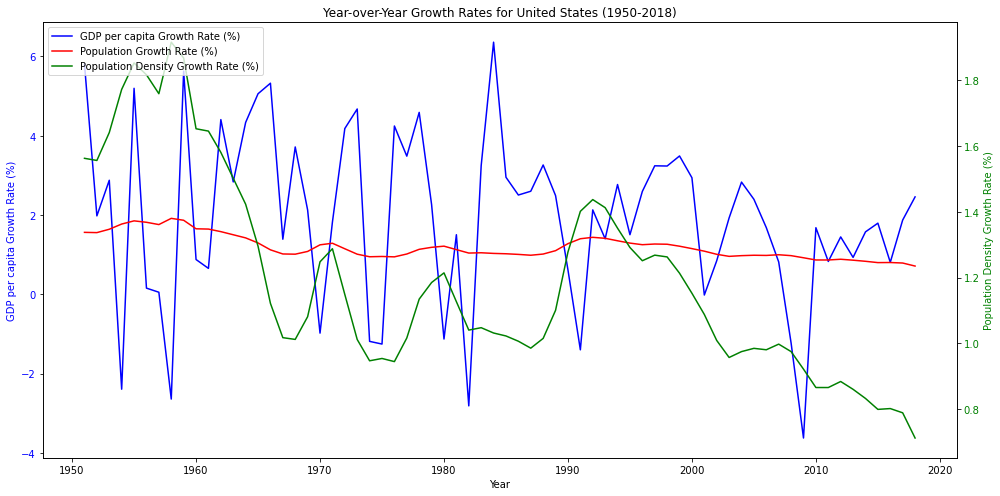

In [17]:
plot_growth_rates_with_secondary_axis('United States', gdp_data_detailed, density_data_detailed, population_data_detailed)

2

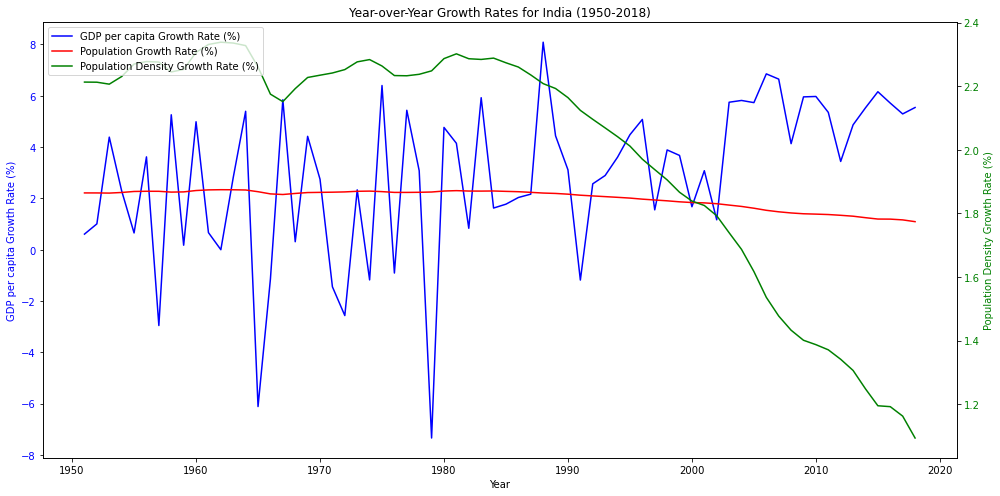

In [18]:
plot_growth_rates_with_secondary_axis('India', gdp_data_detailed, density_data_detailed, population_data_detailed)

3

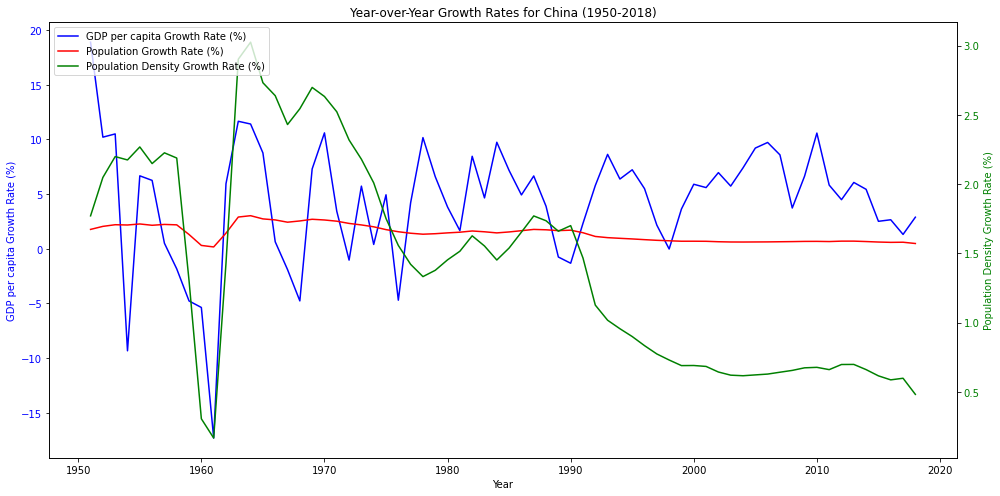

In [19]:
# Define the function to calculate growth rates and plot the graph with secondary axis for Bahrain
plot_growth_rates_with_secondary_axis('China', gdp_data_detailed, density_data_detailed, population_data_detailed)

4

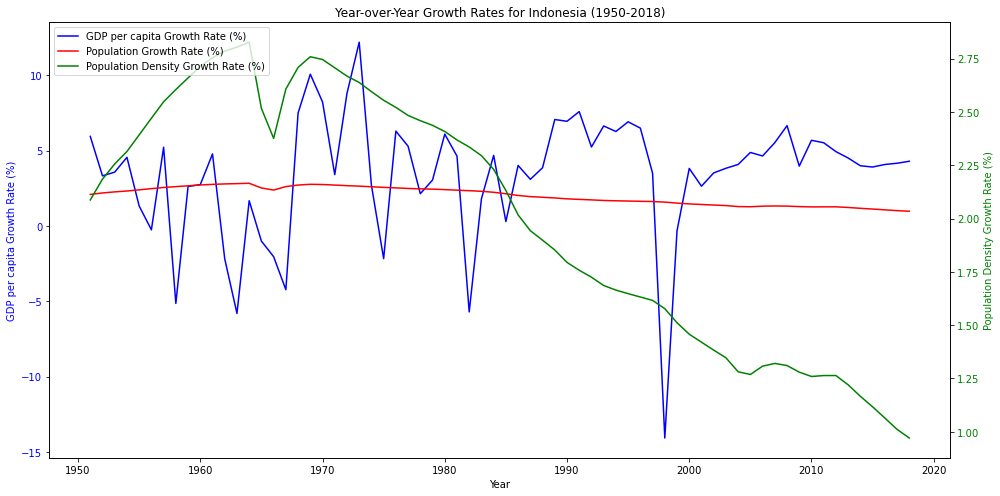

In [20]:
plot_growth_rates_with_secondary_axis('Indonesia', gdp_data_detailed, density_data_detailed, population_data_detailed)

5

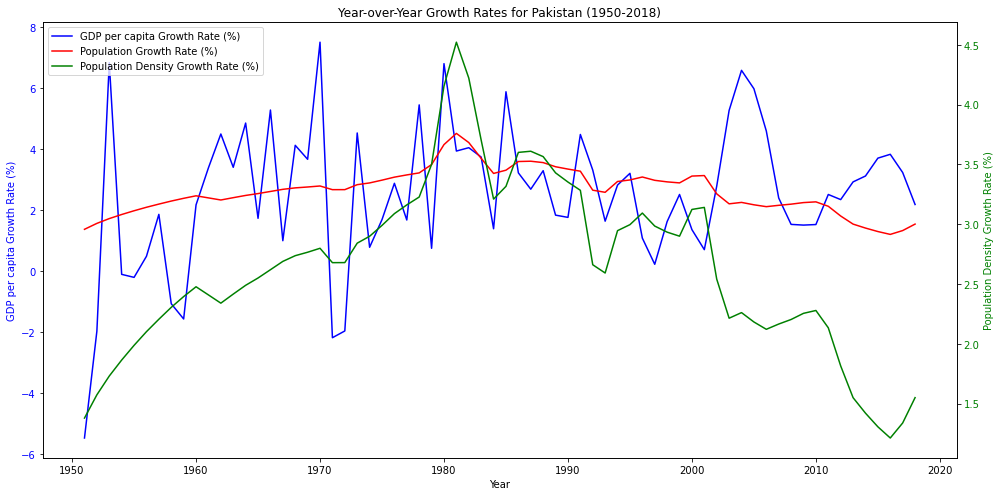

In [21]:
plot_growth_rates_with_secondary_axis('Pakistan', gdp_data_detailed, density_data_detailed, population_data_detailed)

# Comparison of the Top 5 Countries for Density Growth from 1950-2018 and their GDP and Population growth during this same period

1

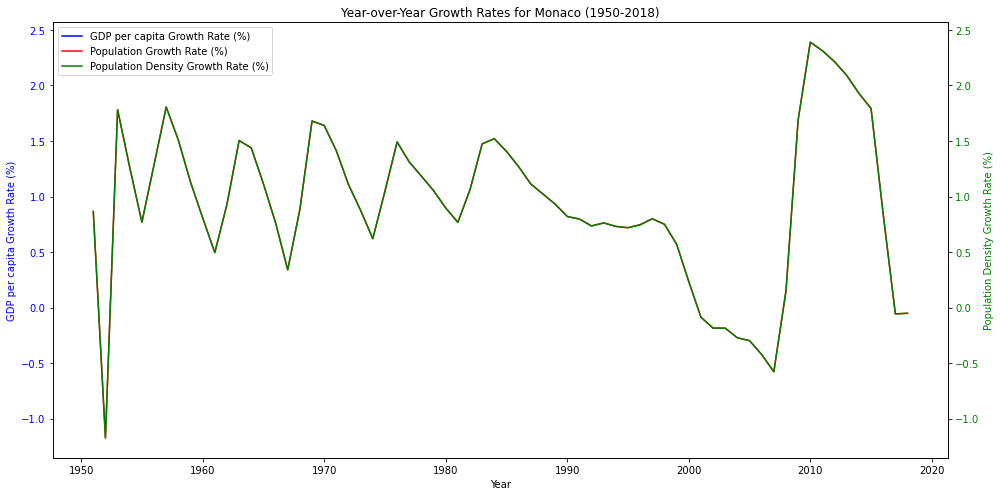

In [22]:
plot_growth_rates_with_secondary_axis('Monaco', gdp_data_detailed, density_data_detailed, population_data_detailed)

2

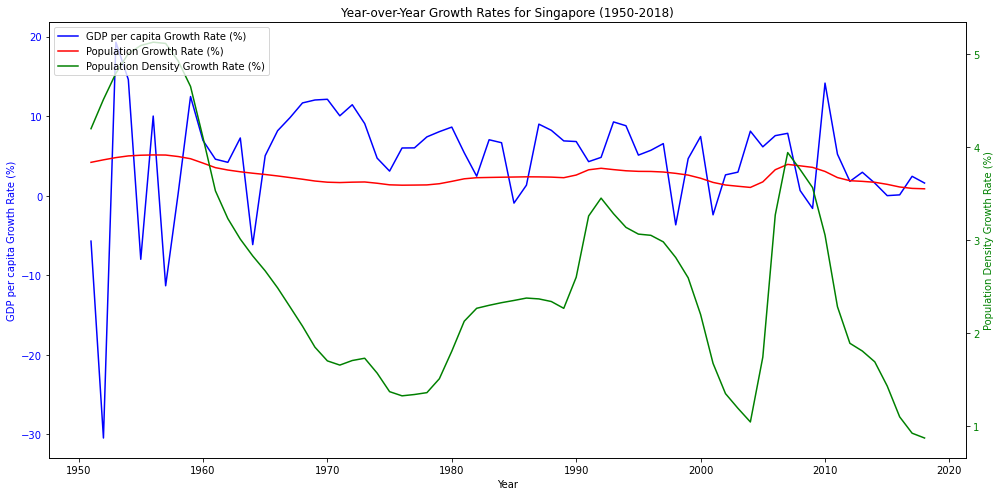

In [23]:
plot_growth_rates_with_secondary_axis('Singapore', gdp_data_detailed, density_data_detailed, population_data_detailed)

3

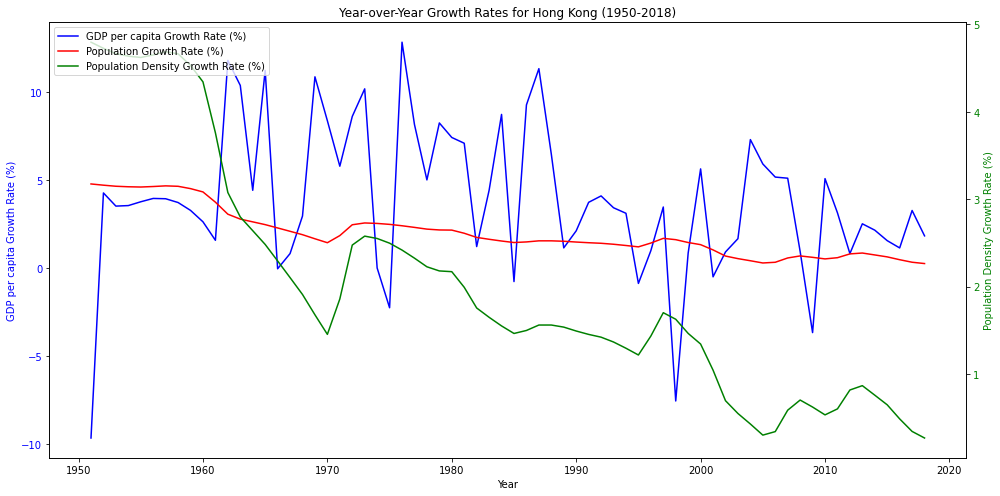

In [24]:
plot_growth_rates_with_secondary_axis('Hong Kong', gdp_data_detailed, density_data_detailed, population_data_detailed)

4

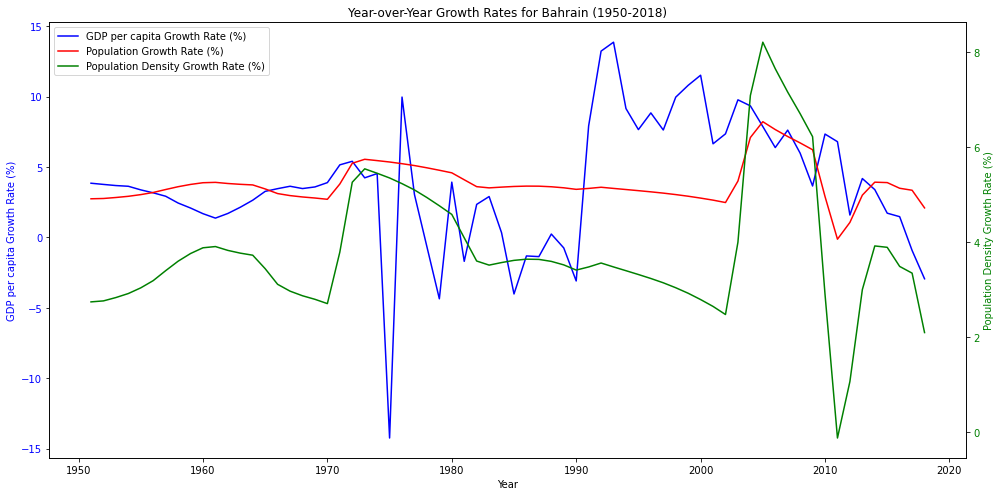

In [25]:
plot_growth_rates_with_secondary_axis('Bahrain', gdp_data_detailed, density_data_detailed, population_data_detailed)

5

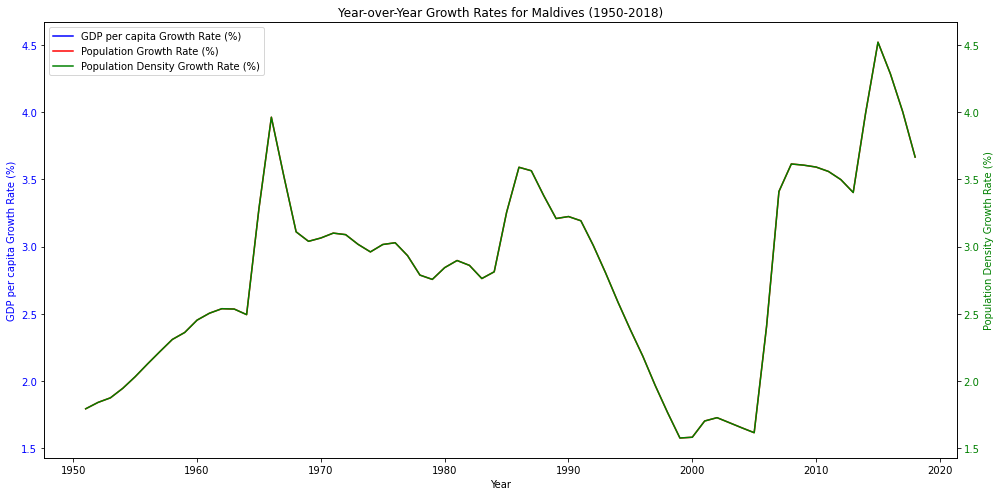

In [26]:
plot_growth_rates_with_secondary_axis('Maldives', gdp_data_detailed, density_data_detailed, population_data_detailed)

# Comparison of the Top 5 Countries for Density Growth from 1950-2018 and their GDP and Population growth during this same period

1

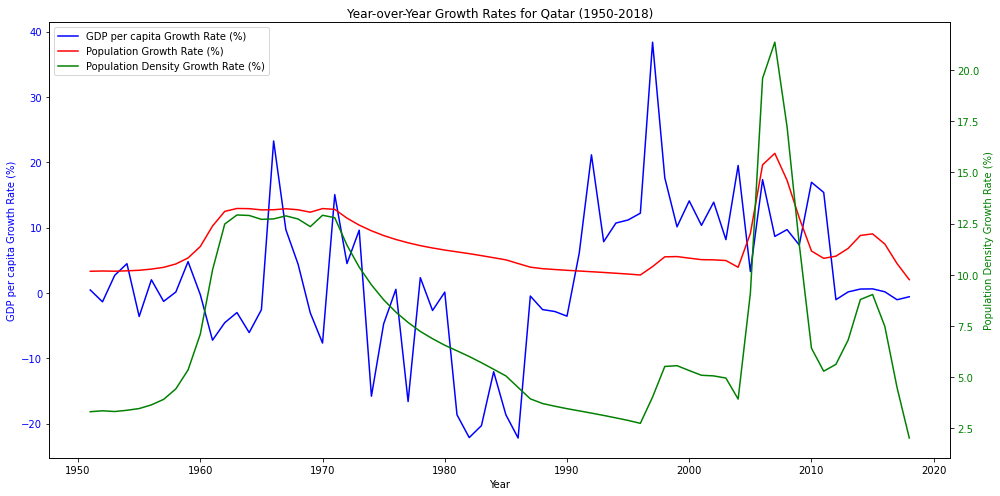

In [27]:
plot_growth_rates_with_secondary_axis('Qatar', gdp_data_detailed, density_data_detailed, population_data_detailed)

2

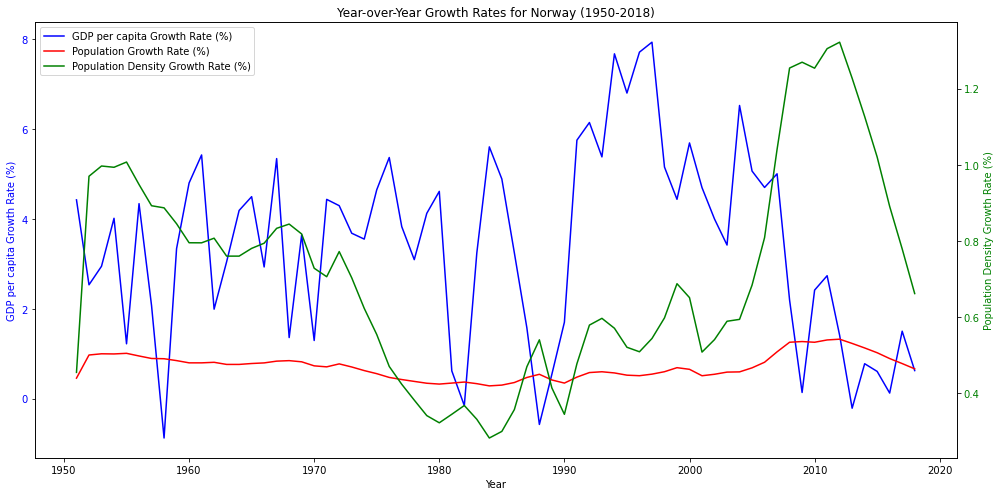

In [28]:
plot_growth_rates_with_secondary_axis('Norway', gdp_data_detailed, density_data_detailed, population_data_detailed)

3

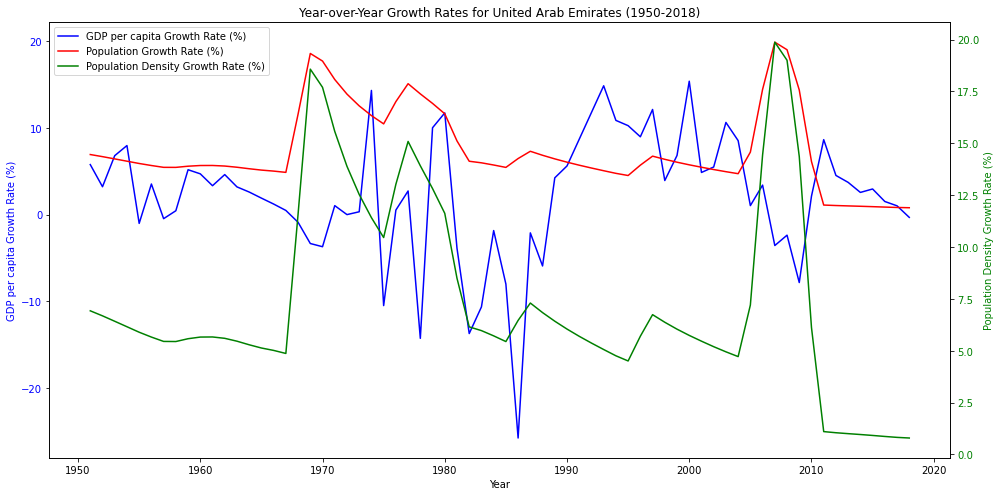

In [29]:
plot_growth_rates_with_secondary_axis('United Arab Emirates', gdp_data_detailed, density_data_detailed, population_data_detailed)

4

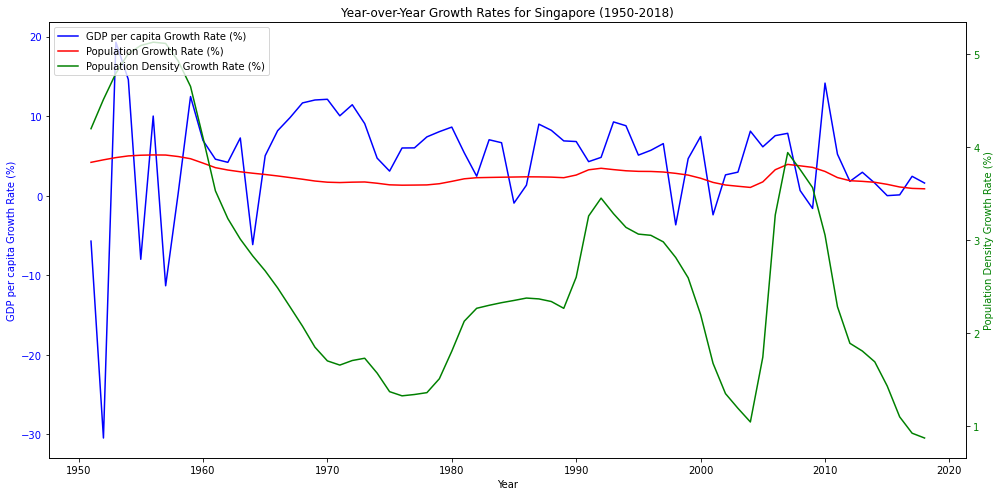

In [30]:
plot_growth_rates_with_secondary_axis('Singapore', gdp_data_detailed, density_data_detailed, population_data_detailed)

5

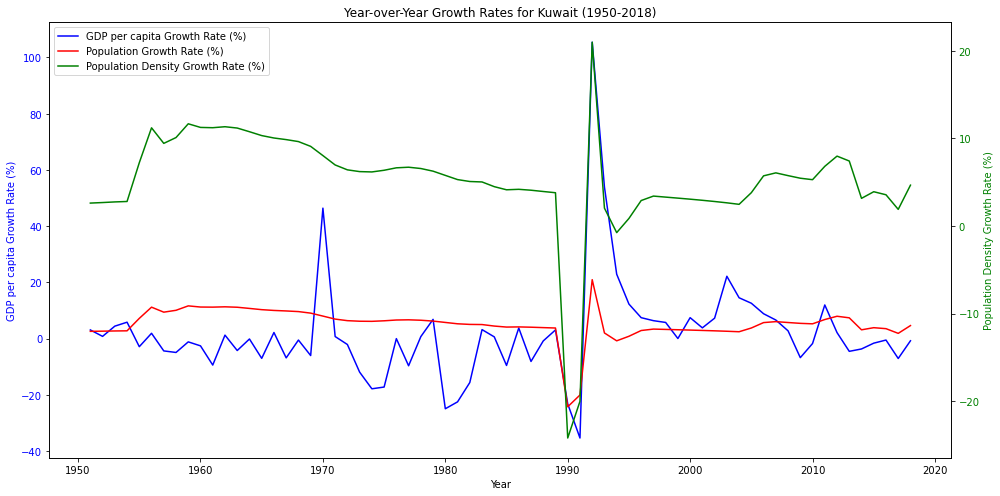

In [31]:
plot_growth_rates_with_secondary_axis('Kuwait', gdp_data_detailed, density_data_detailed, population_data_detailed)

# Quality of Life 2018 Rankings

In [32]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tabulate import tabulate

url = "https://www.numbeo.com/quality-of-life/rankings_by_country.jsp?title=2018&displayColumn=0"
response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

table_rows = soup.find_all('tr')

data = []
for row in table_rows:
    cells = row.find_all('td')
    row_data = [cell.text.strip() for cell in cells]
    data.append(row_data)

if len(data) > 0:
    data = data[1:50]

    df = pd.DataFrame(data, columns=['', 'Country', 'Quality of Life Index (2018)'])

    table = tabulate(df, headers='keys', tablefmt='fancy_grid')
    print(table)

    df.to_csv('Quality of Life 2018 Rankings.csv', index=False)
else:
    print("No data found on the website.")

╒════╤════╤════════════════════════╤════════════════════════════════╕
│    │    │ Country                │   Quality of Life Index (2018) │
╞════╪════╪════════════════════════╪════════════════════════════════╡
│  0 │    │                        │                                │
├────┼────┼────────────────────────┼────────────────────────────────┤
│  1 │    │ Denmark                │                          197.7 │
├────┼────┼────────────────────────┼────────────────────────────────┤
│  2 │    │ Finland                │                          195.3 │
├────┼────┼────────────────────────┼────────────────────────────────┤
│  3 │    │ Netherlands            │                          191.3 │
├────┼────┼────────────────────────┼────────────────────────────────┤
│  4 │    │ Switzerland            │                          190.8 │
├────┼────┼────────────────────────┼────────────────────────────────┤
│  5 │    │ Austria                │                          190.2 │
├────┼────┼─────────

Quality of Life 2018 Rankings: For the countries found in the study

In [33]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tabulate import tabulate

url = "https://www.numbeo.com/quality-of-life/rankings_by_country.jsp?title=2018&displayColumn=0"
response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

table_rows = soup.find_all('tr')

data = []
for row in table_rows:
    cells = row.find_all('td')
    if len(cells) >= 3:
        row_data = [cell.text.strip() for cell in cells]
        data.append(row_data)

if len(data) > 0:
    data = data[1:50]

    df = pd.DataFrame(data, columns=['', 'Country', 'Quality of Life Index'])

    countries = ['Qatar', 'Norway', 'United Arab Emirates', 'Singapore', 'Kuwait',
    'Monaco', 'Hong Kong', 'Bahrain', 'Maldives', 'India',
    'China', 'Indonesia', 'United States', 'Pakistan']

    updated_data = []
    found_countries = []
    
    for country in countries:
        found = False
        for row in data:
            if country.lower() in row[1].lower():
                if country not in found_countries:
                    updated_data.append(row)
                    found_countries.append(country)
                else:
                    print(f"Duplicate country found: {country}")
                found = True
                break
        if not found:
            updated_data.append(['', country, 'No ranking in QoL'])

    updated_df = pd.DataFrame(updated_data, columns=['', 'Country', 'Quality of Life Index (2018)'])

    updated_df = updated_df.sort_values(by='Quality of Life Index (2018)', ascending=False)

    
    updated_df = pd.concat(
        [updated_df[updated_df['Quality of Life Index (2018)'] != 'No ranking in QoL'],
         updated_df[updated_df['Quality of Life Index (2018)'] == 'No ranking in QoL']],
        ignore_index=True)

    updated_df = updated_df.reset_index(drop=True)

    table = tabulate(updated_df, headers='keys', tablefmt='fancy_grid')

    print(table)

    df.to_csv('Quality of Life 2018 Rankings: For the countries found in our study.csv', index=False)
else:
    print("No data found on the website.")

╒════╤════╤══════════════════════╤════════════════════════════════╕
│    │    │ Country              │ Quality of Life Index (2018)   │
╞════╪════╪══════════════════════╪════════════════════════════════╡
│  0 │    │ United States        │ 180.6                          │
├────┼────┼──────────────────────┼────────────────────────────────┤
│  1 │    │ Norway               │ 176.3                          │
├────┼────┼──────────────────────┼────────────────────────────────┤
│  2 │    │ United Arab Emirates │ 163.5                          │
├────┼────┼──────────────────────┼────────────────────────────────┤
│  3 │    │ Qatar                │ 159.6                          │
├────┼────┼──────────────────────┼────────────────────────────────┤
│  4 │    │ Singapore            │ 150.5                          │
├────┼────┼──────────────────────┼────────────────────────────────┤
│  5 │    │ India                │ 122.1                          │
├────┼────┼──────────────────────┼──────────────

# Interactive Map

In [34]:
import pandas as pd
import folium
from folium import IFrame
import base64
import os

# Load the provided CSV files
growth_data_file_path = 'Consolidated_Growth_Data.csv'
quality_of_life_file_path = 'Quality of Life 2018 Rankings.csv'

# Reading the files into DataFrames
growth_data_df = pd.read_csv(growth_data_file_path, encoding='ISO-8859-1')
quality_of_life_df = pd.read_csv(quality_of_life_file_path, encoding='ISO-8859-1')

# Merging the two dataframes based on the 'Country' column
merged_data_df = pd.merge(growth_data_df, quality_of_life_df, on='Country', how='left')

# Handling missing values in the Quality of Life Index column
merged_data_df['Quality of Life Index (2018)'] = merged_data_df['Quality of Life Index (2018)'].fillna("No Data Available")

# Function to encode image to base64
def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string

def create_popup_content(country, image_directory, merged_data_df):
    # Check if the country exists in the DataFrame
    if country not in merged_data_df['Country'].values:
        return f"<strong>{country}</strong><br>No Data Available<br>"

    # Retrieve the data for the specified country
    country_data = merged_data_df[merged_data_df['Country'] == country].iloc[0]

    # Start HTML content
    html_content = f"<strong>{country}</strong><br>"

    # Extract and format the data for display
    population_growth = country_data['Population_increase_millions_since_1950-2018']
    gdp_growth = country_data['GDP_increase_since_1950_2018']
    density_growth = country_data['Increase in Density Since 1950-2018 (people per Km Squared)']
    quality_of_life_index = country_data['Quality of Life Index (2018)']

    # Add formatted values to the HTML content
    html_content += f"Population Growth: {population_growth}<br>"
    html_content += f"GDP Growth: {gdp_growth}<br>"
    html_content += f"Density Growth: {density_growth}<br>"
    html_content += f"Quality of Life Index (2018): {quality_of_life_index}<br>"

    # Append image if it exists
    image_path = os.path.join(image_directory, f"{country}_growth_rates.png")
    if os.path.isfile(image_path):
        encoded_image = encode_image_to_base64(image_path)
        html_content += f'<img src="data:image/png;base64,{encoded_image}" width="300" height="200" style="margin-top:10px;">'
    else:
        html_content += "Image Not Available<br>"

    return html_content
# Dictionary of country names and their respective latitude and longitude
country_coordinates = {'Qatar': (25.5, 51.25),
    'Norway': (62.0, 10.0),
    'United Arab Emirates': (24.0, 54.0),
    'Singapore': (1.35, 103.82),
    'Kuwait': (29.5, 47.75),
    'Monaco': (43.73, 7.42),
    'Hong Kong': (22.3, 114.2),
    'Bahrain': (26.0, 50.55),
    'Maldives': (3.2, 73.0),
    'India': (20.59, 78.96),
    'China': (35.86, 104.19),
    'Indonesia': (-0.79, 113.92),
    'United States': (37.09, -95.71),
    'Pakistan': (30.37, 69.34)}

# Directory where images are stored
image_directory = '.'

# Initialize the map
m = folium.Map(location=[20, 0], zoom_start=2)

# Add TileLayer
folium.TileLayer('OpenStreetMap', no_wrap=True).add_to(m)

# Loop to add markers to the map
for country, coordinates in country_coordinates.items():
    html_content = create_popup_content(country, image_directory, merged_data_df)
    iframe = IFrame(html_content, width=350, height=250)
    folium.Marker(
        location=coordinates,
        popup=folium.Popup(iframe, max_width=350),
        tooltip=country).add_to(m)
    
# Save the map to an HTML file
m.save('interactive_map.html')

print("The interactive map has been saved in the current directory.")

The interactive map has been saved in the current directory.
